### This notebook shows how to 

In [68]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [69]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [70]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [71]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: UKY: { cpu: 6/6 , core: 184/192 , ram: 1,512/1,536 G, disk: 9,560/9,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 8,000/10,000 G, unit: 8/10 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
	Site Interfaces:
		UKY_LBNL: TrunkPort { bw: 100/100 Gbps}
RENC
	Components:
	Site Interfaces:
STAR
	Components:
	Site Interfaces:
LBNL: { cpu: 6/6 , core: 184/192 , ram: 1,512/1,536 G, disk: 9,560/9,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 379/381 }
		NVME-P4510:  NVME P4510 { disk: 9,000/10,000 G, unit: 9/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 1/2 }
		SmartNIC-ConnectX-5:  SmartNIC Connect

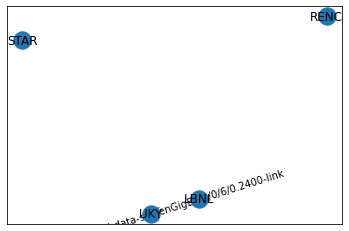

In [72]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

We will request two nodes. We will attach a smart NIC to one of them, and a shared NIC to the other. Configurations for the NICs are going to be different.

The setup is shown below:

<img src="./l2bridge-tagged.png">

In [73]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='LBNL')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='LBNL')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Dedicated Cardsn1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name='n2-nic1')


# For Tagged Bridge, specify VLAN
for i in t.interface_list:
    if_labels = i.get_property(pname="labels")
    if_labels.vlan = "200"
    i.set_properties(labels=if_labels)

# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2bridge-ded-tag2', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "c600a4f9-8afe-44f5-ac20-1e963c8be97b",
    "lease_end": "2021-08-10 20:23:48",
    "pending_state": "None_",
    "reservation_id": "77376013-08b4-4381-87e7-d4ae6c492b47",
    "reservation_state": "Unknown",
    "slice_id": "7b0bc119-59cf-4c8d-ac07-87411b49a8db"
}, {
    "graph_node_id": "5ef4d8bd-8a5e-454c-9a8b-c0458ea43dde",
    "lease_end": "2021-08-10 20:23:48",
    "pending_state": "None_",
    "reservation_id": "88747d5e-c20c-4bb6-871c-4a8fc63f5623",
    "reservation_state": "Unknown",
    "slice_id": "7b0bc119-59cf-4c8d-ac07-87411b49a8db"
}, {
    "graph_node_id": "bdc3698c-4fac-4c15-8627-ad32b77c350b",
    "lease_end": "2021-08-10 20:23:48",
    "pending_state": "None_",
    "reservation_id": "bb848bf0-b112-437d-aaf4-a53fb6035ed7",
    "reservation_state": "Unknown",
    "slice_id": "7b0bc119-59cf-4c8d-ac07-87411b49a8db"
}]


In [74]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [77]:
status, slices = slice_manager.slices() #(state="All")

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "c80811fd-4b16-452b-b529-abb85f47b59d",
    "lease_end": "2021-08-10 20:23:48",
    "slice_id": "7b0bc119-59cf-4c8d-ac07-87411b49a8db",
    "slice_name": "Slice-l2bridge-ded-tag2",
    "slice_state": "StableOK"
}]


## Query Slivers

In [78]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000000ef\", \"instance_parent\": \"lbnl-w2.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 6}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "c600a4f9-8afe-44f5-ac20-1e963c8be97b",
    "join_state": "NoJoin",
    "lease_end": "2021-08-10 20:23:48",
    "management_ip": "198.129.61.43",
    "name": "n1",
    "pending_state": "None_",
    "reservation_id": "77376013-08b4-4381-87e7-d4ae6c492b47",
    "reservation_state": "Active",
    "resource_type": "VM",
    "site": "LBNL",
    "slice_id": "7b0bc119-59cf-4c8d-ac07-87411b49a8db"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000000ee\", \"instance_parent\": \"lbnl-w3.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"dis

### Now let's connect to the nodes with paramiko.

In [79]:
import paramiko

In [82]:
slivers[0].management_ip

'198.129.61.43'

In [81]:
slivers[1].management_ip

'198.129.61.38'

In [86]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(slivers[0].management_ip,username='ubuntu',pkey = key)

client1

In [87]:
stdin, stdout, stderr = client1.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [88]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client2 = paramiko.SSHClient()
client2.load_system_host_keys()
client2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client2.connect(slivers[1].management_ip,username='ubuntu',pkey = key)

client2

In [89]:
stdin, stdout, stderr = client2.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



### Let's try to let the nodes ping each other through their management IPs.

In [91]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + slivers[1].management_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.38 (198.129.61.38) 56(84) bytes of data.
64 bytes from 198.129.61.38: icmp_seq=1 ttl=63 time=0.848 ms
64 bytes from 198.129.61.38: icmp_seq=2 ttl=63 time=0.360 ms
64 bytes from 198.129.61.38: icmp_seq=3 ttl=63 time=0.320 ms
64 bytes from 198.129.61.38: icmp_seq=4 ttl=63 time=0.292 ms
64 bytes from 198.129.61.38: icmp_seq=5 ttl=63 time=0.339 ms

--- 198.129.61.38 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4086ms
rtt min/avg/max/mdev = 0.292/0.431/0.848/0.209 ms




In [92]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + slivers[0].management_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 198.129.61.43 (198.129.61.43) 56(84) bytes of data.
64 bytes from 198.129.61.43: icmp_seq=1 ttl=63 time=0.207 ms
64 bytes from 198.129.61.43: icmp_seq=2 ttl=63 time=0.287 ms
64 bytes from 198.129.61.43: icmp_seq=3 ttl=63 time=0.286 ms
64 bytes from 198.129.61.43: icmp_seq=4 ttl=63 time=0.273 ms
64 bytes from 198.129.61.43: icmp_seq=5 ttl=63 time=0.238 ms

--- 198.129.61.43 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4097ms
rtt min/avg/max/mdev = 0.207/0.258/0.287/0.031 ms




### We can see that both nodes are able to ping each other. This should be made possible by the control plane.

### We want to let the nodes communicate through the bridge that we have requested.

### To begin with, we will need to use the `route` command. So we need to install `net-tools`.

In [93]:
stdin, stdout, stderr = client1.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [792 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [156 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8408 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [330 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [47.6 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [460 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [635 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [98.5 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univer

### Let's see what interfaces we have.

In [94]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:02:33:cf brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.88/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85778sec preferred_lft 85778sec
    inet6 fe80::f816:3eff:fe02:33cf/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 36:84:ba:31:0e:88 brd ff:ff:ff:ff:ff:ff




### Node `n1` has only one interface (`ens8`), because we have requested a shared NIC.

In [95]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:5c:d6:f3 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.110/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 85772sec preferred_lft 85772sec
    inet6 fe80::f816:3eff:fe5c:d6f3/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:0e brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 0c:42:a1:91:75:0f brd ff:ff:ff:ff:ff:ff




### Node `n2` has two interfaces (`ens7` and `ens8`).

<hr>

### Now let's configure our interfaces.

### Let's begin by configuring `n1`'s NIC.

### For a shared NIC, we don't need to worry about the tags. We can directly assign an IP address to the interface.

In [97]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [98]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's configure `n2`'s NIC.

### We need to add a new interface that picks traffic tagged `200` (as we specified when we were creating the slice).

### We are going to create two "vlan" interfaces called `ens7.200` and `ens8.200`. They are going to pick traffic tagged `200` from their corresponding interfaces (`ens7` and `ens8` respectively).

### And then we will assign IP addresses to `ens7.200` and `ens8.200`.

In [99]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [100]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [101]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [102]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.21.51/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [103]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens8 name ens8.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [104]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [105]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [106]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.22.51/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Next thing to do is add routes.

### For `n1`, we are going to direct traffic going to both `192.168.11.0` and `192.168.12.0` through `ens8`

In [120]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.21.0/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [121]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.22.0/24 dev ens8')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### For `n2`, we are going to direct traffic going to `192.168.10.0` through `ens7.200`.

In [110]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.10.0/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's ping

In [122]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.21.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.21.51 (192.168.21.51) 56(84) bytes of data.
64 bytes from 192.168.21.51: icmp_seq=1 ttl=64 time=0.163 ms
64 bytes from 192.168.21.51: icmp_seq=2 ttl=64 time=0.140 ms
64 bytes from 192.168.21.51: icmp_seq=3 ttl=64 time=0.064 ms
64 bytes from 192.168.21.51: icmp_seq=4 ttl=64 time=0.065 ms
64 bytes from 192.168.21.51: icmp_seq=5 ttl=64 time=0.070 ms

--- 192.168.21.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4076ms
rtt min/avg/max/mdev = 0.064/0.100/0.163/0.042 ms




In [123]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.22.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.22.51 (192.168.22.51) 56(84) bytes of data.
64 bytes from 192.168.22.51: icmp_seq=1 ttl=64 time=0.140 ms
64 bytes from 192.168.22.51: icmp_seq=2 ttl=64 time=0.053 ms
64 bytes from 192.168.22.51: icmp_seq=3 ttl=64 time=0.054 ms
64 bytes from 192.168.22.51: icmp_seq=4 ttl=64 time=0.070 ms
64 bytes from 192.168.22.51: icmp_seq=5 ttl=64 time=0.079 ms

--- 192.168.22.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4098ms
rtt min/avg/max/mdev = 0.053/0.079/0.140/0.031 ms




In [125]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.118 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.078 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.081 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.070 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.058 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4085ms
rtt min/avg/max/mdev = 0.058/0.081/0.118/0.020 ms




### We can see that the interfaces are able to communicate to each other.

<hr>

In [126]:
stdin, stdout, stderr = client1.exec_command('ip a && route -n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:02:33:cf brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.88/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 84478sec preferred_lft 84478sec
    inet6 fe80::f816:3eff:fe02:33cf/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 36:84:ba:31:0e:88 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.51/24 scope global ens8
       valid_lft forever preferred_lft forever
    inet6 fe80::3484:baff:fe31:e88/64 scope link 
       valid_lft forever preferred

In [127]:
stdin, stdout, stderr = client2.exec_command('ip a && route -n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:5c:d6:f3 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.110/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 84471sec preferred_lft 84471sec
    inet6 fe80::f816:3eff:fe5c:d6f3/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 0c:42:a1:91:75:0e brd ff:ff:ff:ff:ff:ff
    inet6 fe80::e42:a1ff:fe91:750e/64 scope link 
       valid_lft forever preferred_lft forever
4: ens8: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group d